# Exemples

Ces notes permettent de se tester les méthodes développées pour le positionnement du robot par un LiDAR s'appuyant sur des balises fixes.

On a besoin de **numpy** pour traiter les données comme des vecteurs et de matplolib pour afficher les données.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
# from matplotlib.pyplot import rcParams
# rcParams['figure.figsize'] = 20, 20
pl.figure(figsize=(15,13))

# %matplotlib inline
%matplotlib notebook

In [2]:
from lidarproc.main.constants import *
import lidarproc.main.clustering as clus
import lidarproc.main.data_cleansing as dacl
import lidarproc.main.output_rendering as outr
from lidarproc.retrieve_realistic_measures import get_table_measures
import lidarproc.check_hough as chh
import lidarproc.check_clustering as chc

On récupère une série de mesures parmi les trois enregistrées le 26 avril 2019.

In [3]:
samples = ["0_-1820_pi_over_2", "1210_1400_pi", "-1210_1400_0"]
one_turn_measure = get_table_measures(samples[1])

On a pris 9 tours de mesures par position.

In [4]:
len(one_turn_measure)

9

Un tour de mesures est composé de 1197 mesures.

In [5]:
len(one_turn_measure[0])

1197

Et la résolution angulaire est de 0,3°, ce qui est vraiment pas mal !

In [6]:
one_turn_measure[0][1][0] - one_turn_measure[0][0][0]

0.30219999999999997

On fait un tri des mesures. Le LiDAR annonce lui-même pour chaque mesure si celle-ci est de bonne qualité ou non. Ca va de 0 à 180. On ne conserve finalement que points.

9
935


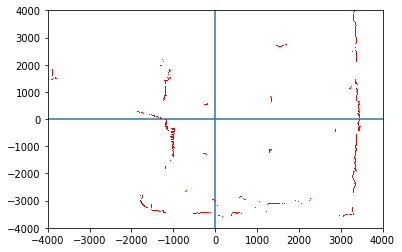

In [7]:
print(len(one_turn_measure))
%matplotlib inline
one_turn_measure = get_table_measures(samples[1])
one_turn_measure = dacl.keep_good_measures(one_turn_measure[0], 100)
print(len(one_turn_measure))
# chh.display_measures(one_turn_measure)


# pl.ion()
fig = pl.figure()
ax = fig.add_subplot(111)
ax.clear()
ax.set_xlim(-distance_max_x_cartesien, distance_max_x_cartesien)
ax.set_ylim(-distance_max_y_cartesien, distance_max_y_cartesien)
ax.axhline(0, 0)
ax.axvline(0, 0)
# pl.grid()

polar_points = [[np.radians(theta), rho] for theta, rho in one_turn_measure]

points = outr.one_turn_to_cartesian_points(polar_points)

xx = []
yy = []
for x, y in points:
    xx.append(x)
    yy.append(y)

pl.plot(xx, yy, 'r,')
fig.canvas.draw()
pl.show()

On peut encore nettoyer : si un point est trop loin du robot alors on peut considérer qu'il est n'est pas de l'environnement de jeu du robot, donc on rejette.

503


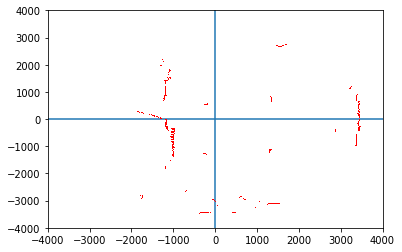

In [8]:
%matplotlib inline
one_turn_measure = dacl.keep_not_too_far_or_not_too_close(one_turn_measure)
print(len(one_turn_measure))
# chh.display_measures(one_turn_measure)

# pl.ion()
fig = pl.figure()
ax = fig.add_subplot(111)
ax.clear()
ax.set_xlim(-distance_max_x_cartesien, distance_max_x_cartesien)
ax.set_ylim(-distance_max_y_cartesien, distance_max_y_cartesien)
ax.axhline(0, 0)
ax.axvline(0, 0)
# pl.grid()

polar_points = [[np.radians(theta), rho] for theta, rho in one_turn_measure]

points = outr.one_turn_to_cartesian_points(polar_points)

xx = []
yy = []
for x, y in points:
    xx.append(x)
    yy.append(y)

pl.plot(xx, yy, 'r,')
fig.canvas.draw()
pl.show()

On convertit les données en coordonnées cartésiennes et on les regroupe dans des groupes nommés *clusters*.

In [9]:
print(one_turn_measure[0])
cartesian_one_turn_measure = outr.one_turn_to_cartesian_points([(np.radians(theta), rho) for theta, rho in one_turn_measure])
print(cartesian_one_turn_measure[0])
cartesian_one_turn_measure = [np.array(measure) for measure in cartesian_one_turn_measure]
clusters, means, closest_points = clus.clusterize(cartesian_one_turn_measure)

[0.7306, 3428.0]
[3427.72131153   43.71053071]


On peut voir les *clusters*. Chaque cluster a sa propre couleur.

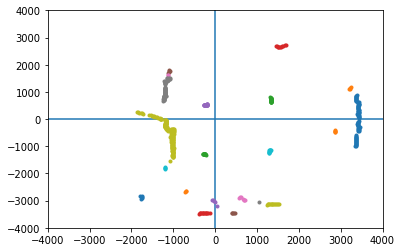

In [10]:
%matplotlib inline
chc.plot_clustering(clusters)

On cherche les *clusters* qui ont une forme sensiblement proche d'une balise fixe recherchée.

In [11]:
real_clusters = []
circle_centers = []
for cluster in clusters:
    c = clus.Cluster()
    c.add_points(cluster)
    real_clusters.append(c)
for cluster in real_clusters:
    res = cluster.is_a_fix_beacon()
#     print(res.fun)
    if res is not None:
        circle_centers.append(res.center)
        

On entoure les zones présumées être des balises fixes d'un cerlce rouge.

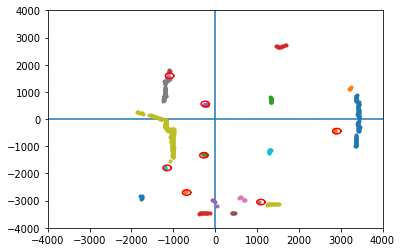

In [12]:
%matplotlib inline
thetas = np.deg2rad(np.arange(0, 360, 1))
real_radius = 100


chc.plot_clustering(clusters, False)
for circle_center in circle_centers:
    xx = circle_center.x + real_radius*np.cos(thetas)
    yy = circle_center.y + real_radius*np.sin(thetas)
    pl.plot(xx, yy, "r-")
pl.show()

Et là, on ne part plus du tout de mesures réelles, mais de simulation que l'on fait en bruitant les points qui se trouvent sur le cercle construit.

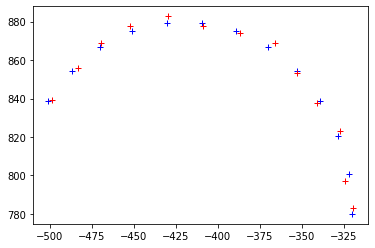

In [13]:
%matplotlib inline
thetas = np.deg2rad(np.arange(0, 150, 12))
real_x, real_y = (-420, 780)
real_radius = 100
sigma = 3
xx_real = real_radius * np.cos(thetas) + real_x
xx_noisy = real_radius * np.cos(thetas) + real_x + np.random.randn(len(thetas))*sigma
yy_real = real_radius * np.sin(thetas) + real_y
yy_noisy = real_radius * np.sin(thetas) + real_y + np.random.randn(len(thetas))*sigma


pl.plot(xx_real, yy_real, 'b+')
pl.plot(xx_noisy, yy_noisy, 'r+')
pl.show()

On regarde si ça donne bien un cercle au final et on affiche la reconstitution.

In [14]:
%matplotlib inline
sigma = 2
points = [np.array([xx_noisy[i], yy_noisy[i]])+np.random.randn(2)*sigma for i in range(len(xx_noisy))]
cluster = clus.Cluster()
cluster.add_points(points)
xy = cluster.is_a_circle(100)

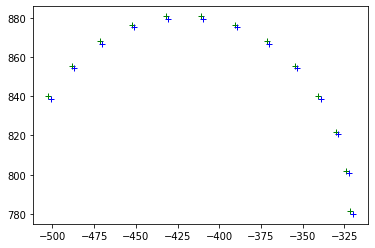

In [15]:

%matplotlib inline
real_radius = 100

xx_reconstructed = real_radius * np.cos(thetas) + xy.x[0]
yy_reconstructed = real_radius * np.sin(thetas) + xy.x[1]

pl.plot(xx_reconstructed, yy_reconstructed, 'g+')
pl.plot(xx_real, yy_real, 'b+')
pl.show()

Voilà voilà. Il faut que je bosse vraiment en fait.

---------------------------

Par Clément Besnier, [www.clementbesnier.fr](https://www.clementbesnier.fr)